In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")

CUDA is available.


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ===========================
# Data augmentation and loading
# ===========================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load full training set
full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Split into 40k train and 10k validation
train_size = 40000
val_size = 10000
train_subset, val_subset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

# Data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2)

# Test set remains unchanged
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# ===========================
# Experiment tracking class
# ===========================
class ExperimentTracker:
    def __init__(self):
        self.results = defaultdict(list)

    def log(self, experiment_name, epoch, train_loss, train_acc, val_loss, val_acc):
        self.results[experiment_name].append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    def plot_comparison(self, experiment_names, title="Training Comparison", save_path=None):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

        for i, exp_name in enumerate(experiment_names):
            if exp_name not in self.results:
                continue

            data = self.results[exp_name]
            epochs = [d['epoch'] for d in data]
            train_losses = [d['train_loss'] for d in data]
            val_losses = [d['val_loss'] for d in data]
            train_accs = [d['train_acc'] for d in data]
            val_accs = [d['val_acc'] for d in data]

            color = colors[i % len(colors)]

            axes[0,0].plot(epochs, train_losses, label=f'{exp_name}', linewidth=2, color=color)
            axes[0,1].plot(epochs, val_losses, label=f'{exp_name}', linewidth=2, color=color)
            axes[1,0].plot(epochs, train_accs, label=f'{exp_name}', linewidth=2, color=color)
            axes[1,1].plot(epochs, val_accs, label=f'{exp_name}', linewidth=2, color=color)

        axes[0,0].set_title('Training Loss')
        axes[0,1].set_title('Validation Loss')
        axes[1,0].set_title('Training Accuracy')
        axes[1,1].set_title('Validation Accuracy')
        for ax in axes.flat:
            ax.set_xlabel('Epoch')
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def get_final_results(self, experiment_name):
        if experiment_name in self.results and self.results[experiment_name]:
            return self.results[experiment_name][-1]
        return None

# Initialize tracker
tracker = ExperimentTracker()

# ===========================
# Custom Batch Normalization (Section 6)
# ===========================



import torch
import torch.nn as nn

class CustomBatchNorm2d(nn.Module):
    """
    Custom Batch Normalization for 2D inputs (N, C, H, W).

    Training:
      - Normalize with batch mean/var (gradients flow through these tensors).
      - Update running_mean and running_var using *detached* batch stats
        so running stats are NOT part of the computation graph.

    Inference:
      - Normalize with running_mean and running_var.

    Args:
        num_features (int): number of channels C
        eps (float): numerical stability term added to variance
        momentum (float): EMA momentum for running statistics
        affine (bool): learnable scale/shift (gamma/beta)
        track_running_stats (bool): keep running mean/var during training
    """

    def __init__(
        self,
        num_features: int,
        eps: float = 1e-5,
        momentum: float = 0.1,
        affine: bool = True,
        track_running_stats: bool = True,
    ):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        # Learnable affine parameters (like PyTorch BatchNorm2d)
        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))  # scale
            self.beta = nn.Parameter(torch.zeros(num_features))  # shift
        else:
            self.register_parameter("gamma", None)
            self.register_parameter("beta", None)

        # Non-trainable buffers for running stats
        if self.track_running_stats:
            self.register_buffer("running_mean", torch.zeros(num_features))
            self.register_buffer("running_var", torch.ones(num_features))
            self.register_buffer("num_batches_tracked", torch.tensor(0, dtype=torch.long))
        else:
            self.register_buffer("running_mean", None)
            self.register_buffer("running_var", None)
            self.register_buffer("num_batches_tracked", None)

        self.reset_parameters()

    def reset_parameters(self):
        """Reset running stats and (optionally) affine parameters."""
        if self.affine:
            nn.init.ones_(self.gamma)
            nn.init.zeros_(self.beta)
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1.0)
            self.num_batches_tracked.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W)
        Returns:
            (N, C, H, W) after normalization and affine transform (if enabled)
        """
        # Compute batch statistics over (N, H, W) for each channel C
        if self.training:
            # Mean/var used for normalization MUST have gradients
            batch_mean = x.mean(dim=(0, 2, 3), keepdim=True)                   # shape: (1, C, 1, 1)
            batch_var  = x.var(dim=(0, 2, 3), unbiased=False, keepdim=True)    # shape: (1, C, 1, 1)

            # Normalize with batch stats (this path participates in backprop)
            x_norm = (x - batch_mean) / torch.sqrt(batch_var + self.eps)

            # ---- Running stats update (no grads by design) -----------------
            # The assignment hint says to use `.detach()` explicitly so that
            # running stats are not part of the autograd graph.
            if self.track_running_stats:
                mean_detached = batch_mean.detach().squeeze()  # (C,)
                var_detached  = batch_var.detach().squeeze()   # (C,)

                # EMA: new = (1 - m) * old + m * batch
                # Use in-place ops on buffers for efficiency
                self.running_mean.mul_(1.0 - self.momentum).add_(self.momentum * mean_detached)
                self.running_var.mul_(1.0 - self.momentum).add_(self.momentum * var_detached)
                self.num_batches_tracked.add_(1)
            # ----------------------------------------------------------------

        else:
            # In eval mode, use stable running statistics
            if self.track_running_stats and self.running_mean is not None:
                mean = self.running_mean[None, :, None, None].to(x.device)  # (1, C, 1, 1)
                var  = self.running_var[None, :, None, None].to(x.device)   # (1, C, 1, 1)
            else:
                # Fallback: if not tracking stats, behave like instance norm over batch
                mean = x.mean(dim=(0, 2, 3), keepdim=True)
                var  = x.var(dim=(0, 2, 3), unbiased=False, keepdim=True)

            x_norm = (x - mean) / torch.sqrt(var + self.eps)

        # Affine transform (γ * x_norm + β)
        if self.affine:
            gamma = self.gamma[None, :, None, None]
            beta  = self.beta[None, :, None, None]
            out = gamma * x_norm + beta
        else:
            out = x_norm

        return out

    def extra_repr(self) -> str:
        return (
            f"num_features={self.num_features}, eps={self.eps}, "
            f"momentum={self.momentum}, affine={self.affine}, "
            f"track_running_stats={self.track_running_stats}"
        )

# class CustomBatchNorm2d1(nn.Module):
#     """
#     Custom Batch Normalization for 2D inputs (images).
    
#     Normalizes activations across the batch dimension:
#     - Training: Uses batch statistics (mean, variance)
#     - Inference: Uses running statistics (exponential moving average)
    
#     Args:
#         num_features: Number of channels (C)
#         eps: Small constant for numerical stability (default: 1e-5)
#         momentum: Momentum for running statistics update (default: 0.1)
#     """
    
#     def __init__(self, num_features, eps=1e-5, momentum=0.1):
#         super(CustomBatchNorm2d, self).__init__()
        
#         # Hyperparameters
#         self.eps = eps
#         self.momentum = momentum
        
#         # Learnable parameters (will be updated by optimizer)
#         self.gamma = nn.Parameter(torch.ones(num_features))   # Scale parameter
#         self.beta = nn.Parameter(torch.zeros(num_features))   # Shift parameter
        
#         # Running statistics (non-trainable buffers)
#         # These are updated during training but NOT by the optimizer
#         self.register_buffer('running_mean', torch.zeros(num_features))
#         self.register_buffer('running_var', torch.ones(num_features))
#         self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

#     def forward(self, x):
#         """
#         Forward pass of Batch Normalization.
        
#         Args:
#             x: Input tensor of shape (N, C, H, W)
#                N = batch size
#                C = number of channels
#                H = height
#                W = width
        
#         Returns:
#             Normalized tensor of shape (N, C, H, W)
#         """
        
#         if self.training:
#             # ========================================
#             # TRAINING MODE
#             # ========================================
            
#             # Step 1: Compute batch statistics
#             # Calculate mean and variance across (N, H, W) dimensions
#             # Result shape: (1, C, 1, 1) for broadcasting
#             mean = x.mean(dim=(0, 2, 3), keepdim=True)  
#             var = x.var(dim=(0, 2, 3), unbiased=False, keepdim=True)
            
#             # Step 2: Normalize using batch statistics
#             # THIS IS WHERE GRADIENTS FLOW THROUGH!
#             # Formula: x_norm = (x - μ) / √(σ² + ε)
#             x_norm = (x - mean) / torch.sqrt(var + self.eps)
            
#             # Step 3: Update running statistics (NO gradients needed here)
#             with torch.no_grad():
#                 # Squeeze to match buffer shape: (1, C, 1, 1) → (C,)
#                 batch_mean = mean.squeeze()
#                 batch_var = var.squeeze()
                
#                 # Exponential moving average update
#                 # running_stat = (1 - momentum) * running_stat + momentum * batch_stat
#                 self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
#                 self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
                
#                 # Track number of batches seen (optional, for debugging)
#                 self.num_batches_tracked += 1
        
#         else:
#             # ========================================
#             # INFERENCE MODE
#             # ========================================
            
#             # Use running statistics (stable, accumulated over training)
#             # Reshape from (C,) to (1, C, 1, 1) for broadcasting
#             mean = self.running_mean[None, :, None, None].to(x.device)
#             var = self.running_var[None, :, None, None].to(x.device)
            
#             # Normalize using running statistics
#             x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
#         # ========================================
#         # AFFINE TRANSFORMATION (both modes)
#         # ========================================
        
#         # Apply learnable scale (gamma) and shift (beta)
#         # Reshape parameters from (C,) to (1, C, 1, 1) for broadcasting
#         # Formula: y = γ * x_norm + β
#         out = self.gamma[None, :, None, None] * x_norm + self.beta[None, :, None, None]
        
#         return out
    
#     def extra_repr(self):
#         """
#         String representation for print(model)
#         """
#         return (f'num_features={self.gamma.shape[0]}, '
#                 f'eps={self.eps}, '
#                 f'momentum={self.momentum}')


# ===========================
# ResNet Architecture
# ===========================
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, use_custom_bn=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = CustomBatchNorm2d(planes) if use_custom_bn else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = CustomBatchNorm2d(planes) if use_custom_bn else nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                CustomBatchNorm2d(self.expansion*planes) if use_custom_bn else nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_custom_bn=False):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.use_custom_bn = use_custom_bn
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = CustomBatchNorm2d(64) if use_custom_bn else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.use_custom_bn))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return self.linear(out)

def ResNet18(use_custom_bn=False):
    return ResNet(BasicBlock, [2, 2, 2, 2], use_custom_bn=use_custom_bn)

# ===========================
# Training and validation functions
# ===========================
def train(epoch, net, criterion, trainloader, scheduler, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    if scheduler and not isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

def validate(epoch, net, criterion, valloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return val_loss/(batch_idx+1), 100.*correct/total

In [4]:
# ========================================
# TEST 1: Gradient Flow Verification
# ========================================
def test_gradient_flow():
    print("=" * 60)
    print("TEST 1: Gradient Flow Verification")
    print("=" * 60)
    
    x = torch.randn(8, 64, 32, 32, requires_grad=True)
    
    # Custom BatchNorm
    bn_custom = CustomBatchNorm2d(64)
    bn_custom.train()
    out_custom = bn_custom(x)
    loss_custom = out_custom.sum()
    loss_custom.backward()
    
    # Verify gradients exist
    assert x.grad is not None, "❌ No gradient for input!"
    assert bn_custom.gamma.grad is not None, "❌ No gradient for gamma!"
    assert bn_custom.beta.grad is not None, "❌ No gradient for beta!"
    
    print("✅ Input gradient exists:", x.grad is not None)
    print("✅ Gamma gradient exists:", bn_custom.gamma.grad is not None)
    print("✅ Beta gradient exists:", bn_custom.beta.grad is not None)
    print("✅ All gradients flow correctly!\n")

# ========================================
# TEST 2: Compare with PyTorch BatchNorm
# ========================================
def test_pytorch_comparison():
    print("=" * 60)
    print("TEST 2: Comparison with PyTorch nn.BatchNorm2d")
    print("=" * 60)
    
    torch.manual_seed(42)
    x = torch.randn(8, 64, 32, 32)
    
    # Custom BatchNorm
    bn_custom = CustomBatchNorm2d(64)
    bn_custom.train()
    
    # PyTorch BatchNorm
    bn_pytorch = nn.BatchNorm2d(64)
    bn_pytorch.train()
    
    # Copy parameters to ensure same initialization
    bn_pytorch.weight.data = bn_custom.gamma.data.clone()
    bn_pytorch.bias.data = bn_custom.beta.data.clone()
    
    # Forward pass
    out_custom = bn_custom(x)
    out_pytorch = bn_pytorch(x)
    
    # Compare outputs
    close = torch.allclose(out_custom, out_pytorch, atol=1e-5)
    
    print(f"Custom output mean: {out_custom.mean():.6f}")
    print(f"PyTorch output mean: {out_pytorch.mean():.6f}")
    print(f"Custom output std: {out_custom.std():.6f}")
    print(f"PyTorch output std: {out_pytorch.std():.6f}")
    print(f"Outputs close? {close}")
    
    if close:
        print("✅ Custom implementation matches PyTorch!\n")
    else:
        print("⚠️ Small differences detected (may be due to numerical precision)\n")

# ========================================
# TEST 3: Training vs Inference Mode
# ========================================
def test_train_vs_eval():
    print("=" * 60)
    print("TEST 3: Training vs Inference Mode")
    print("=" * 60)
    
    x = torch.randn(4, 32, 16, 16)
    bn = CustomBatchNorm2d(32)
    
    # Training mode
    bn.train()
    out_train = bn(x)
    
    # Inference mode
    bn.eval()
    out_eval = bn(x)
    
    print(f"Training output mean: {out_train.mean():.6f}")
    print(f"Training output std: {out_train.std():.6f}")
    print(f"Inference output mean: {out_eval.mean():.6f}")
    print(f"Inference output std: {out_eval.std():.6f}")
    
    # They should be different!
    different = not torch.allclose(out_train, out_eval, atol=1e-5)
    print(f"Outputs different? {different}")
    
    if different:
        print("✅ Training and inference modes behave differently (as expected)!\n")
    else:
        print("⚠️ Outputs are the same (unexpected)\n")

# ========================================
# TEST 4: Running Statistics Update
# ========================================
def test_running_stats():
    print("=" * 60)
    print("TEST 4: Running Statistics Update")
    print("=" * 60)
    
    bn = CustomBatchNorm2d(16)
    bn.train()
    
    print("Initial running mean:", bn.running_mean[:5])
    print("Initial running var:", bn.running_var[:5])
    
    # Process several batches
    for i in range(5):
        x = torch.randn(8, 16, 8, 8)
        _ = bn(x)
    
    print("\nAfter 5 batches:")
    print("Running mean:", bn.running_mean[:5])
    print("Running var:", bn.running_var[:5])
    print("Batches tracked:", bn.num_batches_tracked.item())
    
    # Check that running stats have been updated
    mean_updated = not torch.allclose(bn.running_mean, torch.zeros(16))
    var_updated = not torch.allclose(bn.running_var, torch.ones(16))
    
    if mean_updated and var_updated:
        print("✅ Running statistics updated correctly!\n")
    else:
        print("❌ Running statistics not updated!\n")

# ========================================
# TEST 5: Integration with ResNet Block
# ========================================
def test_resnet_integration():
    print("=" * 60)
    print("TEST 5: Integration with ResNet BasicBlock")
    print("=" * 60)
    
    class BasicBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(BasicBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
            self.bn1 = CustomBatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
            self.bn2 = CustomBatchNorm2d(out_channels)
        
        def forward(self, x):
            out = torch.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out = torch.relu(out + x)  # Residual connection
            return out
    
    # Test block
    block = BasicBlock(64, 64)
    block.train()
    
    x = torch.randn(4, 64, 32, 32, requires_grad=True)
    out = block(x)
    loss = out.sum()
    loss.backward()
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {out.shape}")
    print(f"Input has gradient: {x.grad is not None}")
    print(f"BN1 gamma has gradient: {block.bn1.gamma.grad is not None}")
    print(f"BN2 gamma has gradient: {block.bn2.gamma.grad is not None}")
    print("✅ CustomBatchNorm2d works in ResNet block!\n")

# ========================================
# RUN ALL TESTS
# ========================================
if __name__ == "__main__":
    test_gradient_flow()
    test_pytorch_comparison()
    test_train_vs_eval()
    test_running_stats()
    test_resnet_integration()
    
    print("=" * 60)
    print("🎉 ALL TESTS COMPLETED!")
    print("=" * 60)

TEST 1: Gradient Flow Verification
✅ Input gradient exists: True
✅ Gamma gradient exists: True
✅ Beta gradient exists: True
✅ All gradients flow correctly!

TEST 2: Comparison with PyTorch nn.BatchNorm2d
Custom output mean: 0.000000
PyTorch output mean: 0.000000
Custom output std: 0.999996
PyTorch output std: 0.999996
Outputs close? True
✅ Custom implementation matches PyTorch!

TEST 3: Training vs Inference Mode
Training output mean: -0.000000
Training output std: 1.000010
Inference output mean: -0.009450
Inference output std: 0.998447
Outputs different? True
✅ Training and inference modes behave differently (as expected)!

TEST 4: Running Statistics Update
Initial running mean: tensor([0., 0., 0., 0., 0.])
Initial running var: tensor([1., 1., 1., 1., 1.])

After 5 batches:
Running mean: tensor([-0.0159, -0.0061,  0.0027,  0.0028,  0.0054])
Running var: tensor([0.9944, 0.9979, 0.9993, 1.0031, 1.0095])
Batches tracked: 5
✅ Running statistics updated correctly!

TEST 5: Integration with

In [5]:
# Test settings
torch.manual_seed(42)
N, C, H, W = 8, 4, 16, 16
x = torch.randn(N, C, H, W)

# Instantiate layers
custom_bn = CustomBatchNorm2d(C)
torch_bn = nn.BatchNorm2d(C)

# Match initial parameters
custom_bn.gamma.data.copy_(torch_bn.weight.data)
custom_bn.beta.data.copy_(torch_bn.bias.data)

# Training mode test
custom_bn.train()
torch_bn.train()

# Forward pass
out_custom = custom_bn(x)
out_torch = torch_bn(x)

print("Training mode output difference:", (out_custom - out_torch).abs().mean().item())

# Backward pass
loss_custom = out_custom.sum()
loss_torch = out_torch.sum()
loss_custom.backward()
loss_torch.backward()

print("Gradient difference (gamma):", (custom_bn.gamma.grad - torch_bn.weight.grad).abs().mean().item())
print("Gradient difference (beta):", (custom_bn.beta.grad - torch_bn.bias.grad).abs().mean().item())

# Switch to eval mode
custom_bn.eval()
torch_bn.eval()
out_custom_eval = custom_bn(x)
out_torch_eval = torch_bn(x)
print("Eval mode output difference:", (out_custom_eval - out_torch_eval).abs().mean().item())

Training mode output difference: 3.708355222897808e-08
Gradient difference (gamma): 4.072062438353896e-06
Gradient difference (beta): 0.0
Eval mode output difference: 1.959169276233297e-05


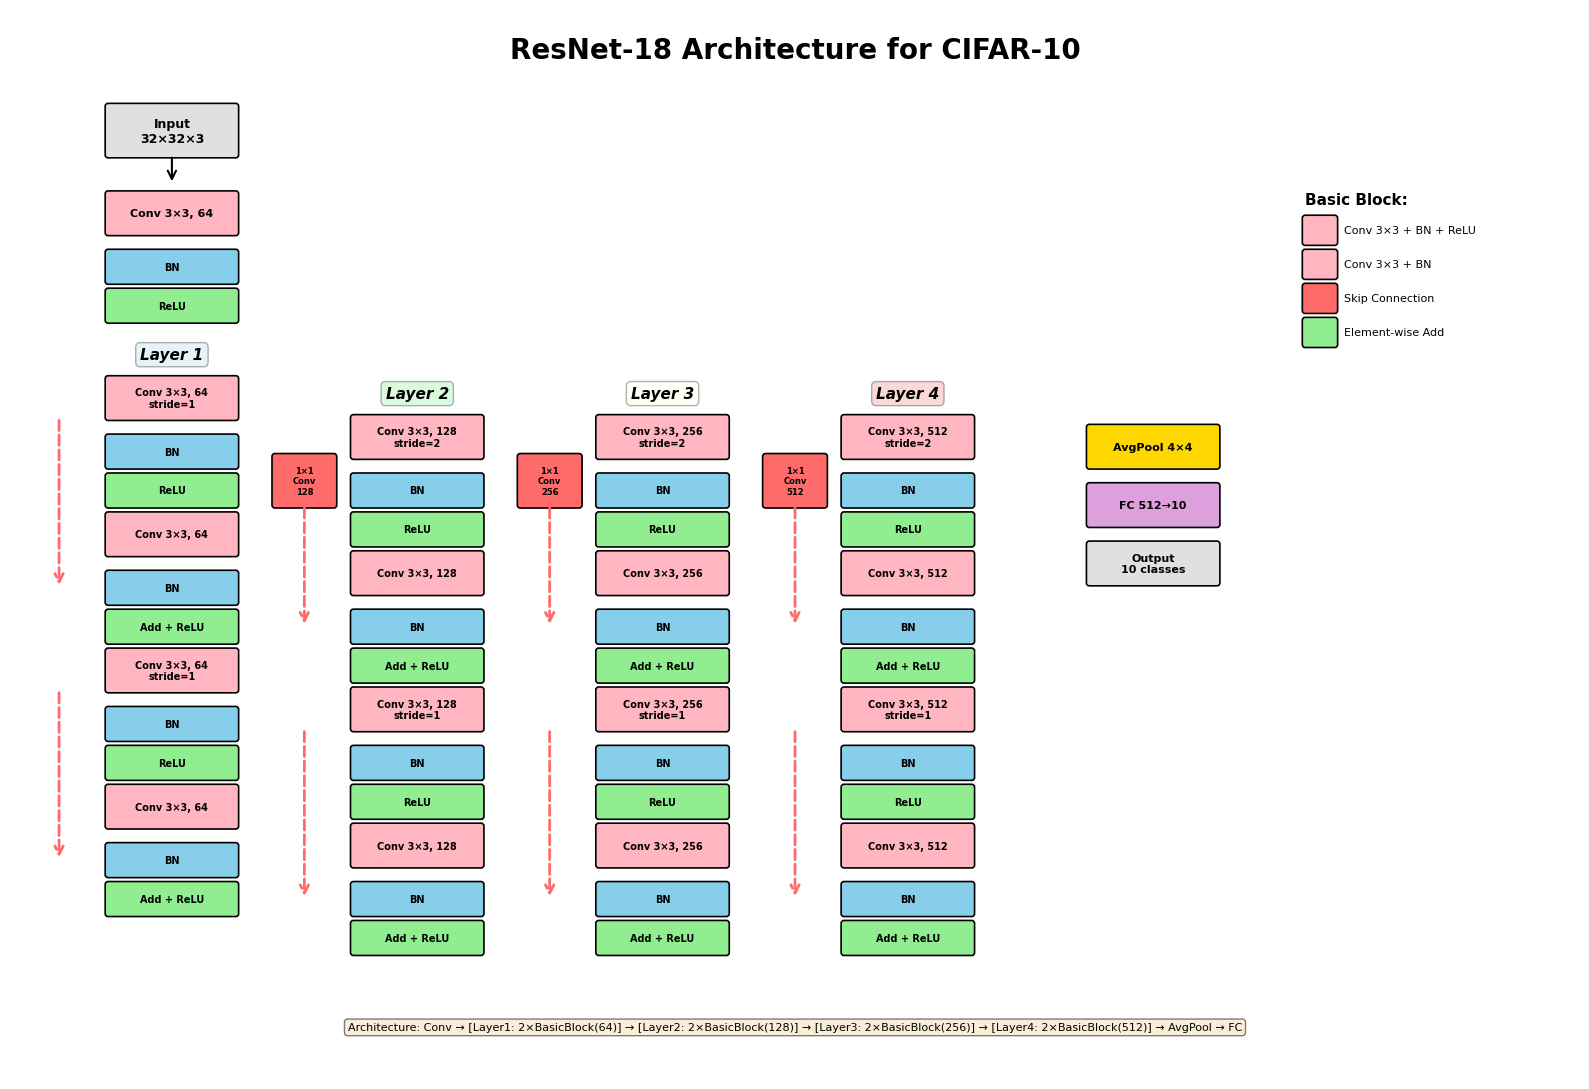

In [6]:

def visualize_resnet_architecture():
    """
    Generate a clean and consistent ResNet-18 architecture diagram for Section 2
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Rectangle

    fig, ax = plt.subplots(figsize=(16, 11))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 11)
    ax.axis('off')

    # Title
    ax.text(8, 10.5, 'ResNet-18 Architecture for CIFAR-10', fontsize=20, fontweight='bold', ha='center')

    # Define colors
    color_conv = '#FFB6C1'
    color_bn = '#87CEEB'
    color_relu = '#90EE90'
    color_pool = '#FFD700'
    color_fc = '#DDA0DD'
    color_residual = '#FF6B6B'

    # Helper function to draw block
    def draw_block(x, y, width, height, color, label, fontsize=8):
        box = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.03",
                            edgecolor='black', facecolor=color, linewidth=1.2)
        ax.add_patch(box)
        ax.text(x + width/2, y + height/2, label, ha='center', va='center',
               fontsize=fontsize, fontweight='bold', wrap=True)

    def draw_arrow(x1, y1, x2, y2, color='black', style='-', width=1.5):
        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                              arrowstyle='->', mutation_scale=15, linewidth=width,
                              color=color, linestyle=style)
        ax.add_patch(arrow)

    # Starting position
    x_pos = 1
    y_start = 9.5
    block_width = 1.3
    block_height = 0.4

    # Input
    draw_block(x_pos, y_start, block_width, 0.5, '#E0E0E0', 'Input\n32×32×3', 9)
    draw_arrow(x_pos + block_width/2, y_start, x_pos + block_width/2, y_start - 0.3, 'black')

    # Initial Conv Block
    y_pos = y_start - 0.8
    draw_block(x_pos, y_pos, block_width, block_height, color_conv, 'Conv 3×3, 64', 8)
    y_pos -= 0.5
    draw_block(x_pos, y_pos, block_width, 0.3, color_bn, 'BN', 7)
    y_pos -= 0.4
    draw_block(x_pos, y_pos, block_width, 0.3, color_relu, 'ReLU', 7)

    # Function to draw a residual block
    def draw_residual_block(x, y, channels, stride=1, has_projection=False):
        block_start_y = y

        # Main path
        draw_block(x, y, block_width, block_height, color_conv, f'Conv 3×3, {channels}\nstride={stride}', 7)
        y -= 0.5
        draw_block(x, y, block_width, 0.3, color_bn, 'BN', 7)
        y -= 0.4
        draw_block(x, y, block_width, 0.3, color_relu, 'ReLU', 7)
        y -= 0.5
        draw_block(x, y, block_width, block_height, color_conv, f'Conv 3×3, {channels}', 7)
        y -= 0.5
        draw_block(x, y, block_width, 0.3, color_bn, 'BN', 7)

        # Skip connection
        skip_x = x - 0.8
        if has_projection:
            # Draw projection shortcut
            proj_y = block_start_y - 0.5
            draw_block(skip_x, proj_y, 0.6, 0.5, color_residual, f'1×1\nConv\n{channels}', 6)
            draw_arrow(skip_x + 0.3, block_start_y, skip_x + 0.3, proj_y + 0.5, color_residual, '--', 2)
            draw_arrow(skip_x + 0.3, proj_y, skip_x + 0.3, y + 0.15, color_residual, '--', 2)
        else:
            # Identity shortcut
            draw_arrow(skip_x + 0.3, block_start_y, skip_x + 0.3, y + 0.15, color_residual, '--', 2)

        # Addition and ReLU
        y -= 0.4
        draw_block(x, y, block_width, 0.3, color_relu, 'Add + ReLU', 7)

        return y - 0.5

    # Layer 1: 2 blocks, 64 channels
    y_pos -= 0.6
    ax.text(x_pos + block_width/2, y_pos + 0.2, 'Layer 1', fontsize=11,
           ha='center', fontweight='bold', style='italic',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    y_pos -= 0.4

    y_pos = draw_residual_block(x_pos, y_pos, 64, stride=1, has_projection=False)
    y_pos = draw_residual_block(x_pos, y_pos, 64, stride=1, has_projection=False)

    # Layer 2: 2 blocks, 128 channels
    x_pos = 3.5
    y_pos = 9.5 - 0.8 - 0.5 - 0.4 - 0.6 - 0.4
    ax.text(x_pos + block_width/2, y_pos + 0.2, 'Layer 2', fontsize=11,
           ha='center', fontweight='bold', style='italic',
           bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    y_pos -= 0.4

    y_pos = draw_residual_block(x_pos, y_pos, 128, stride=2, has_projection=True)
    y_pos = draw_residual_block(x_pos, y_pos, 128, stride=1, has_projection=False)

    # Layer 3: 2 blocks, 256 channels
    x_pos = 6
    y_pos = 9.5 - 0.8 - 0.5 - 0.4 - 0.6 - 0.4
    ax.text(x_pos + block_width/2, y_pos + 0.2, 'Layer 3', fontsize=11,
           ha='center', fontweight='bold', style='italic',
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))
    y_pos -= 0.4

    y_pos = draw_residual_block(x_pos, y_pos, 256, stride=2, has_projection=True)
    y_pos = draw_residual_block(x_pos, y_pos, 256, stride=1, has_projection=False)

    # Layer 4: 2 blocks, 512 channels
    x_pos = 8.5
    y_pos = 9.5 - 0.8 - 0.5 - 0.4 - 0.6 - 0.4
    ax.text(x_pos + block_width/2, y_pos + 0.2, 'Layer 4', fontsize=11,
           ha='center', fontweight='bold', style='italic',
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
    y_pos -= 0.4

    y_pos = draw_residual_block(x_pos, y_pos, 512, stride=2, has_projection=True)
    y_pos = draw_residual_block(x_pos, y_pos, 512, stride=1, has_projection=False)

    # Final layers
    x_pos = 11
    y_pos = 9.5 - 0.8 - 0.5 - 0.4 - 0.6 - 0.4 - 0.5

    draw_block(x_pos, y_pos, block_width, 0.4, color_pool, 'AvgPool 4×4', 8)
    y_pos -= 0.6
    draw_block(x_pos, y_pos, block_width, 0.4, color_fc, 'FC 512→10', 8)
    y_pos -= 0.6
    draw_block(x_pos, y_pos, block_width, 0.4, '#E0E0E0', 'Output\n10 classes', 8)

    # Legend - Basic Block Structure
    legend_x = 13.2
    legend_y = 9
    ax.text(legend_x, legend_y, 'Basic Block:', fontsize=11, fontweight='bold')
    legend_y -= 0.4

    legend_items = [
        ('Conv 3×3 + BN + ReLU', color_conv),
        ('Conv 3×3 + BN', color_conv),
        ('Skip Connection', color_residual),
        ('Element-wise Add', color_relu),
    ]

    for item, color in legend_items:
        draw_block(legend_x, legend_y, 0.3, 0.25, color, '', 6)
        ax.text(legend_x + 0.4, legend_y + 0.125, item, fontsize=8, va='center')
        legend_y -= 0.35

    # Add architecture summary at bottom
    summary_y = 0.5
    summary_text = 'Architecture: Conv → [Layer1: 2×BasicBlock(64)] → [Layer2: 2×BasicBlock(128)] → [Layer3: 2×BasicBlock(256)] → [Layer4: 2×BasicBlock(512)] → AvgPool → FC'
    ax.text(8, summary_y, summary_text, fontsize=8, ha='center',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('resnet18_architecture.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    #print("✓ ResNet-18 architecture diagram saved as 'resnet18_architecture.png'")

# Call this function to generate the diagram
visualize_resnet_architecture()

Using device: cuda
SECTION 3: LEARNING RATE EXPERIMENTS

--- Testing Learning Rate: 0.1 ---


Epoch 5: Train Loss: 1.1110, Train Acc: 60.33%, Val Loss: 1.1170, Val Acc: 60.01%


Epoch 10: Train Loss: 0.6495, Train Acc: 77.09%, Val Loss: 0.6647, Val Acc: 76.21%


Epoch 15: Train Loss: 0.4310, Train Acc: 84.95%, Val Loss: 0.5156, Val Acc: 82.10%
Final - LR 0.1: Train Loss: 0.4310, Train Acc: 84.95%, Val Loss: 0.5156, Val Acc: 82.10%

--- Testing Learning Rate: 0.01 ---


Epoch 5: Train Loss: 0.5716, Train Acc: 80.12%, Val Loss: 0.7708, Val Acc: 75.27%


Epoch 10: Train Loss: 0.3637, Train Acc: 87.54%, Val Loss: 0.4878, Val Acc: 83.13%


Epoch 15: Train Loss: 0.2552, Train Acc: 91.18%, Val Loss: 0.3950, Val Acc: 86.86%
Final - LR 0.01: Train Loss: 0.2552, Train Acc: 91.18%, Val Loss: 0.3950, Val Acc: 86.86%

--- Testing Learning Rate: 0.001 ---


Epoch 5: Train Loss: 0.8208, Train Acc: 70.79%, Val Loss: 0.8623, Val Acc: 69.21%


Epoch 10: Train Loss: 0.5366, Train Acc: 81.20%, Val Loss: 0.5943, Val Acc: 78.95%


Epoch 15: Train Loss: 0.4038, Train Acc: 85.90%, Val Loss: 0.5300, Val Acc: 81.57%
Final - LR 0.001: Train Loss: 0.4038, Train Acc: 85.90%, Val Loss: 0.5300, Val Acc: 81.57%


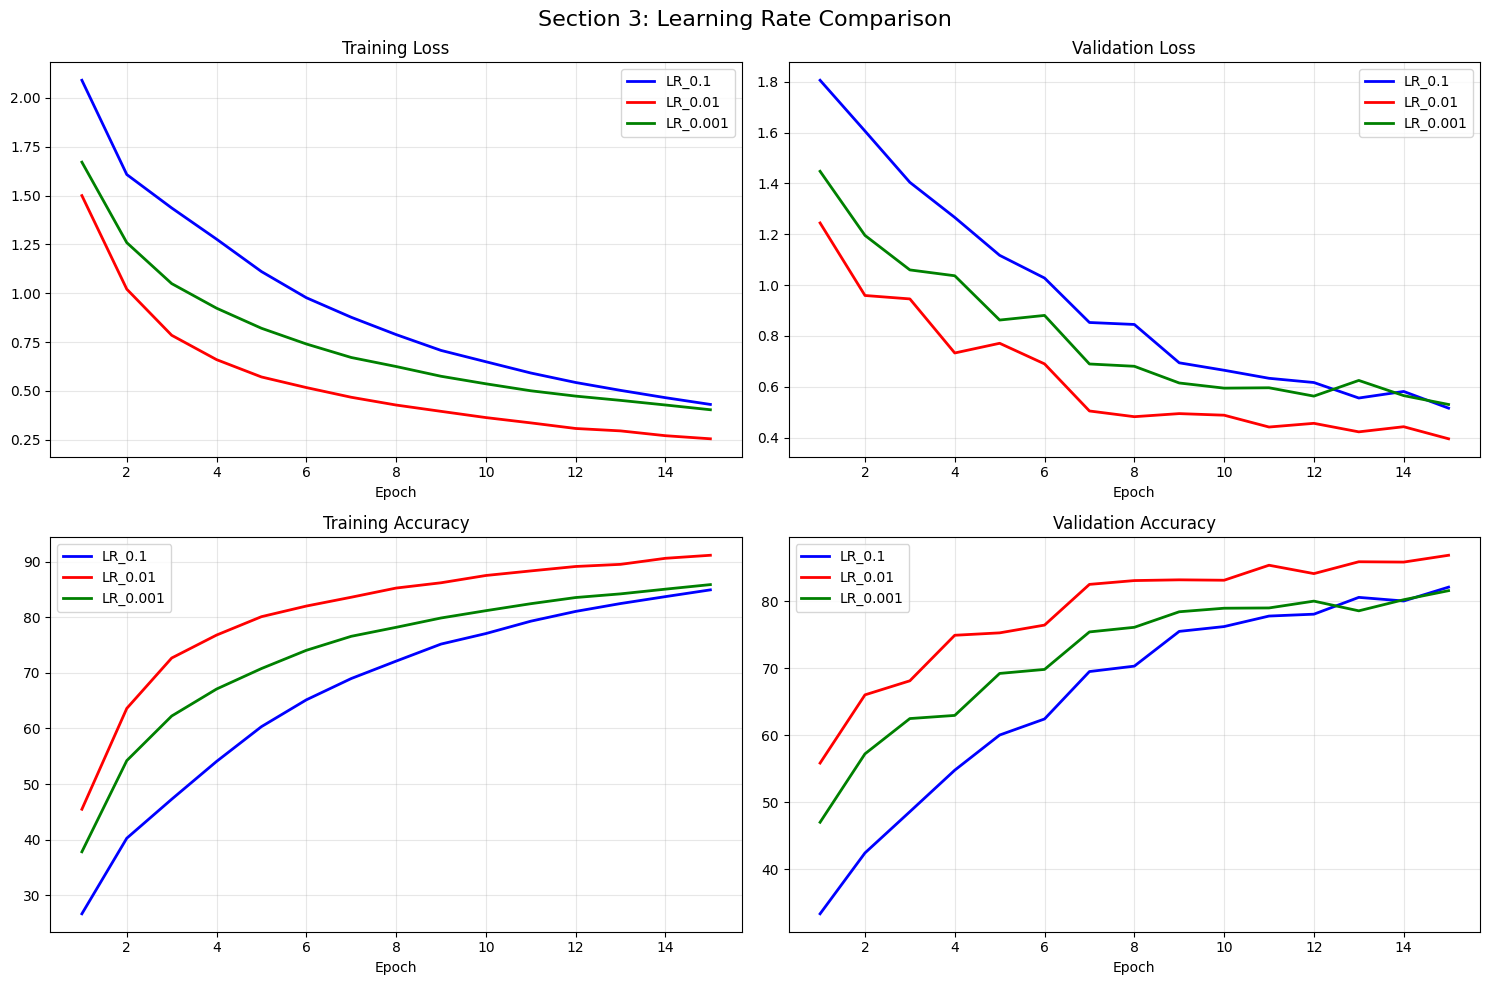


Best Learning Rate: 0.01

SECTION 4: LEARNING RATE SCHEDULING

--- Testing Scheduler: Constant_LR ---


Epoch 50: LR: 0.010000, Train Loss: 0.0374, Train Acc: 98.76%, Val Loss: 0.3628, Val Acc: 90.94%


Epoch 100: LR: 0.010000, Train Loss: 0.0105, Train Acc: 99.65%, Val Loss: 0.4217, Val Acc: 91.88%


Epoch 150: LR: 0.010000, Train Loss: 0.0071, Train Acc: 99.78%, Val Loss: 0.4842, Val Acc: 91.43%


Epoch 200: LR: 0.010000, Train Loss: 0.0034, Train Acc: 99.89%, Val Loss: 0.4950, Val Acc: 91.81%


Epoch 250: LR: 0.010000, Train Loss: 0.0037, Train Acc: 99.86%, Val Loss: 0.4802, Val Acc: 92.15%


Epoch 300: LR: 0.010000, Train Loss: 0.0022, Train Acc: 99.94%, Val Loss: 0.5089, Val Acc: 92.54%
Final - Constant_LR: Train Loss: 0.0022, Train Acc: 99.94%, Val Loss: 0.5089, Val Acc: 92.54%

--- Testing Scheduler: CosineAnnealing ---


Epoch 50: LR: 0.009330, Train Loss: 0.0359, Train Acc: 98.70%, Val Loss: 0.3960, Val Acc: 90.80%


Epoch 100: LR: 0.007500, Train Loss: 0.0052, Train Acc: 99.81%, Val Loss: 0.4160, Val Acc: 92.34%


Epoch 150: LR: 0.005000, Train Loss: 0.0005, Train Acc: 99.99%, Val Loss: 0.4266, Val Acc: 92.98%


Epoch 200: LR: 0.002500, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.4514, Val Acc: 92.74%


Epoch 250: LR: 0.000670, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.4149, Val Acc: 92.89%


Epoch 300: LR: 0.000000, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.4272, Val Acc: 92.93%
Final - CosineAnnealing: Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.4272, Val Acc: 92.93%


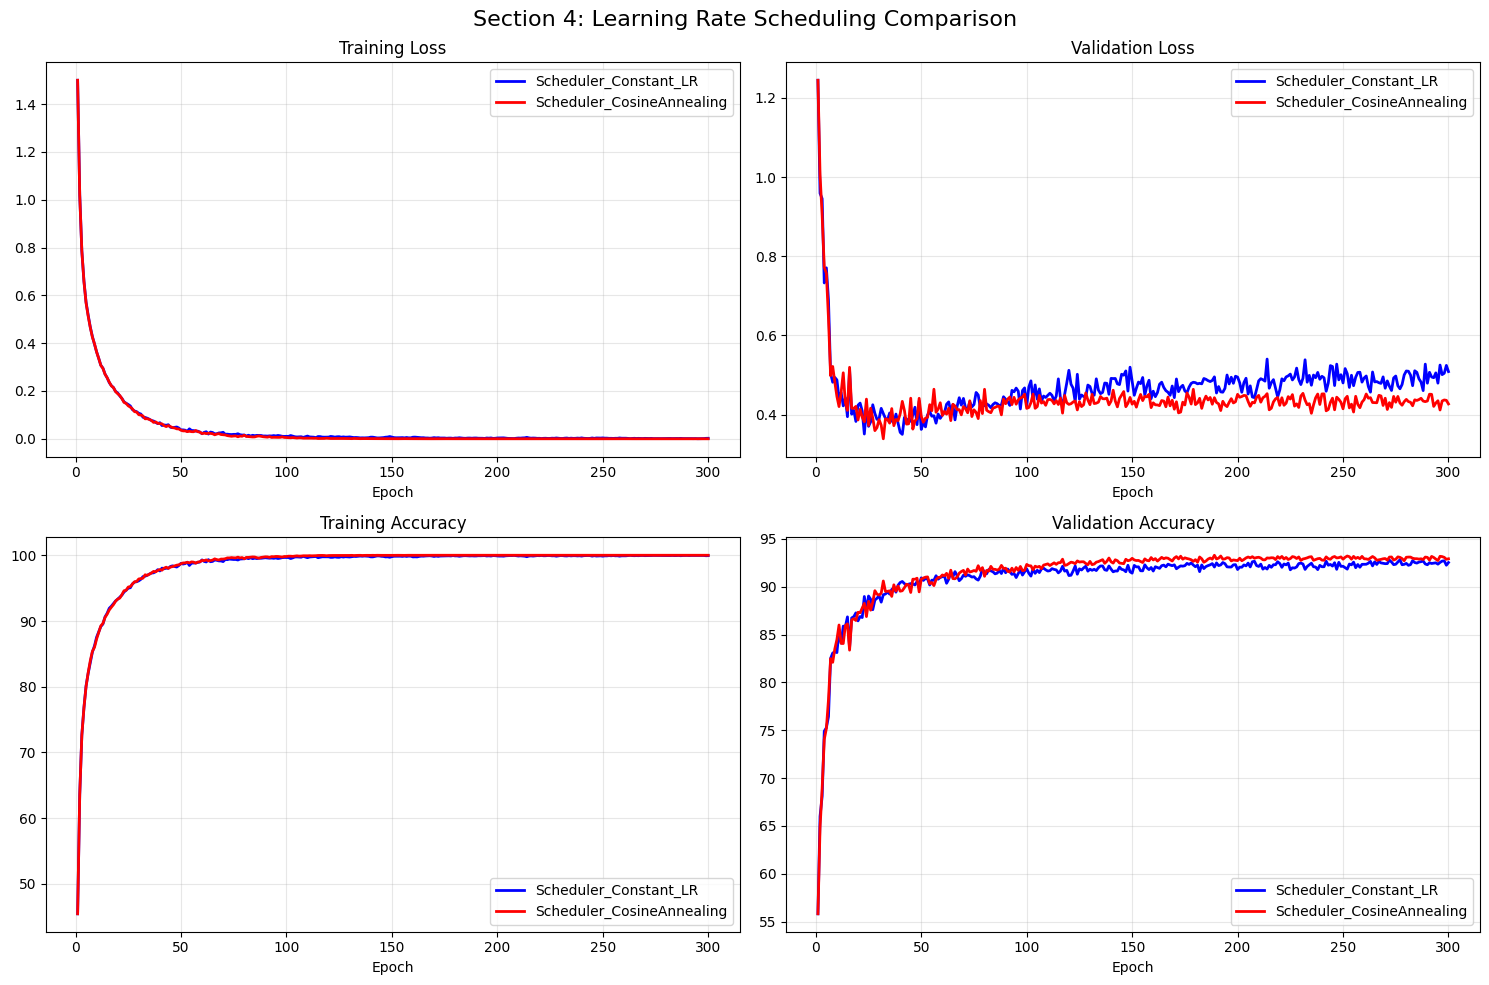


SECTION 5: WEIGHT DECAY EXPERIMENTS

--- Testing Weight Decay: 0.0005 ---


Epoch 50: Train Loss: 0.0578, Train Acc: 98.03%, Val Loss: 0.3714, Val Acc: 89.74%


Epoch 100: Train Loss: 0.0332, Train Acc: 98.91%, Val Loss: 0.3369, Val Acc: 90.89%


Epoch 150: Train Loss: 0.0141, Train Acc: 99.60%, Val Loss: 0.3427, Val Acc: 91.65%


Epoch 200: Train Loss: 0.0011, Train Acc: 100.00%, Val Loss: 0.2505, Val Acc: 93.52%


Epoch 250: Train Loss: 0.0012, Train Acc: 100.00%, Val Loss: 0.2444, Val Acc: 93.95%


Epoch 300: Train Loss: 0.0012, Train Acc: 100.00%, Val Loss: 0.2390, Val Acc: 94.15%
Final - WD 0.0005: Train Loss: 0.0012, Train Acc: 100.00%, Val Loss: 0.2390, Val Acc: 94.15%

--- Testing Weight Decay: 0.01 ---


Epoch 50: Train Loss: 0.4470, Train Acc: 85.61%, Val Loss: 0.7733, Val Acc: 74.23%


Epoch 100: Train Loss: 0.3955, Train Acc: 87.22%, Val Loss: 0.8139, Val Acc: 73.37%


Epoch 150: Train Loss: 0.3088, Train Acc: 90.29%, Val Loss: 0.4598, Val Acc: 84.91%


Epoch 200: Train Loss: 0.1865, Train Acc: 94.51%, Val Loss: 0.3120, Val Acc: 89.58%


Epoch 250: Train Loss: 0.0493, Train Acc: 99.20%, Val Loss: 0.2619, Val Acc: 92.88%


Epoch 300: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1824, Val Acc: 95.05%
Final - WD 0.01: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1824, Val Acc: 95.05%


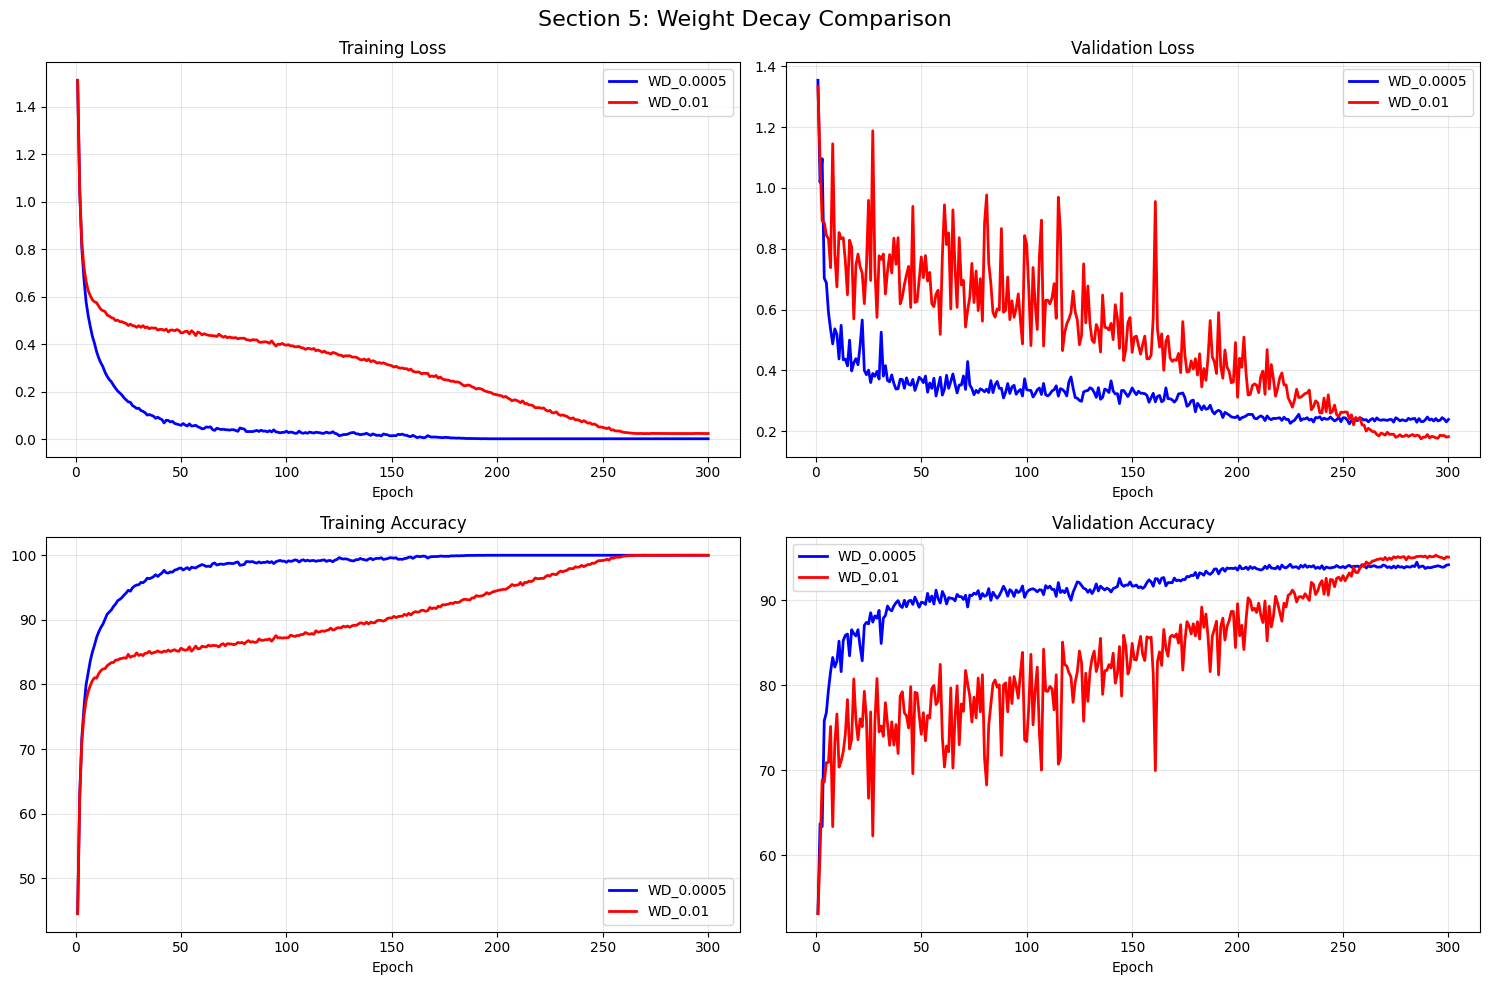


Best Weight Decay: 0.01

SECTION 6: CUSTOM BATCH NORMALIZATION

--- Testing: Standard_BN ---


Epoch 50: Train Loss: 0.4470, Train Acc: 85.61%, Val Loss: 0.7733, Val Acc: 74.23%


Epoch 100: Train Loss: 0.3955, Train Acc: 87.22%, Val Loss: 0.8139, Val Acc: 73.37%


Epoch 150: Train Loss: 0.3088, Train Acc: 90.29%, Val Loss: 0.4598, Val Acc: 84.91%


Epoch 200: Train Loss: 0.1865, Train Acc: 94.51%, Val Loss: 0.3120, Val Acc: 89.58%


Epoch 250: Train Loss: 0.0493, Train Acc: 99.20%, Val Loss: 0.2619, Val Acc: 92.88%


Epoch 300: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1824, Val Acc: 95.05%
Final - Standard_BN: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1824, Val Acc: 95.05%

--- Testing: Custom_BN ---


Epoch 50: Train Loss: 0.4509, Train Acc: 85.41%, Val Loss: 0.6941, Val Acc: 76.86%


Epoch 100: Train Loss: 0.3980, Train Acc: 87.31%, Val Loss: 0.5763, Val Acc: 81.16%


Epoch 150: Train Loss: 0.3108, Train Acc: 90.25%, Val Loss: 0.4690, Val Acc: 84.45%


Epoch 200: Train Loss: 0.1874, Train Acc: 94.57%, Val Loss: 0.3415, Val Acc: 89.02%


Epoch 250: Train Loss: 0.0501, Train Acc: 99.17%, Val Loss: 0.2637, Val Acc: 92.56%


Epoch 300: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1872, Val Acc: 95.11%
Final - Custom_BN: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1872, Val Acc: 95.11%


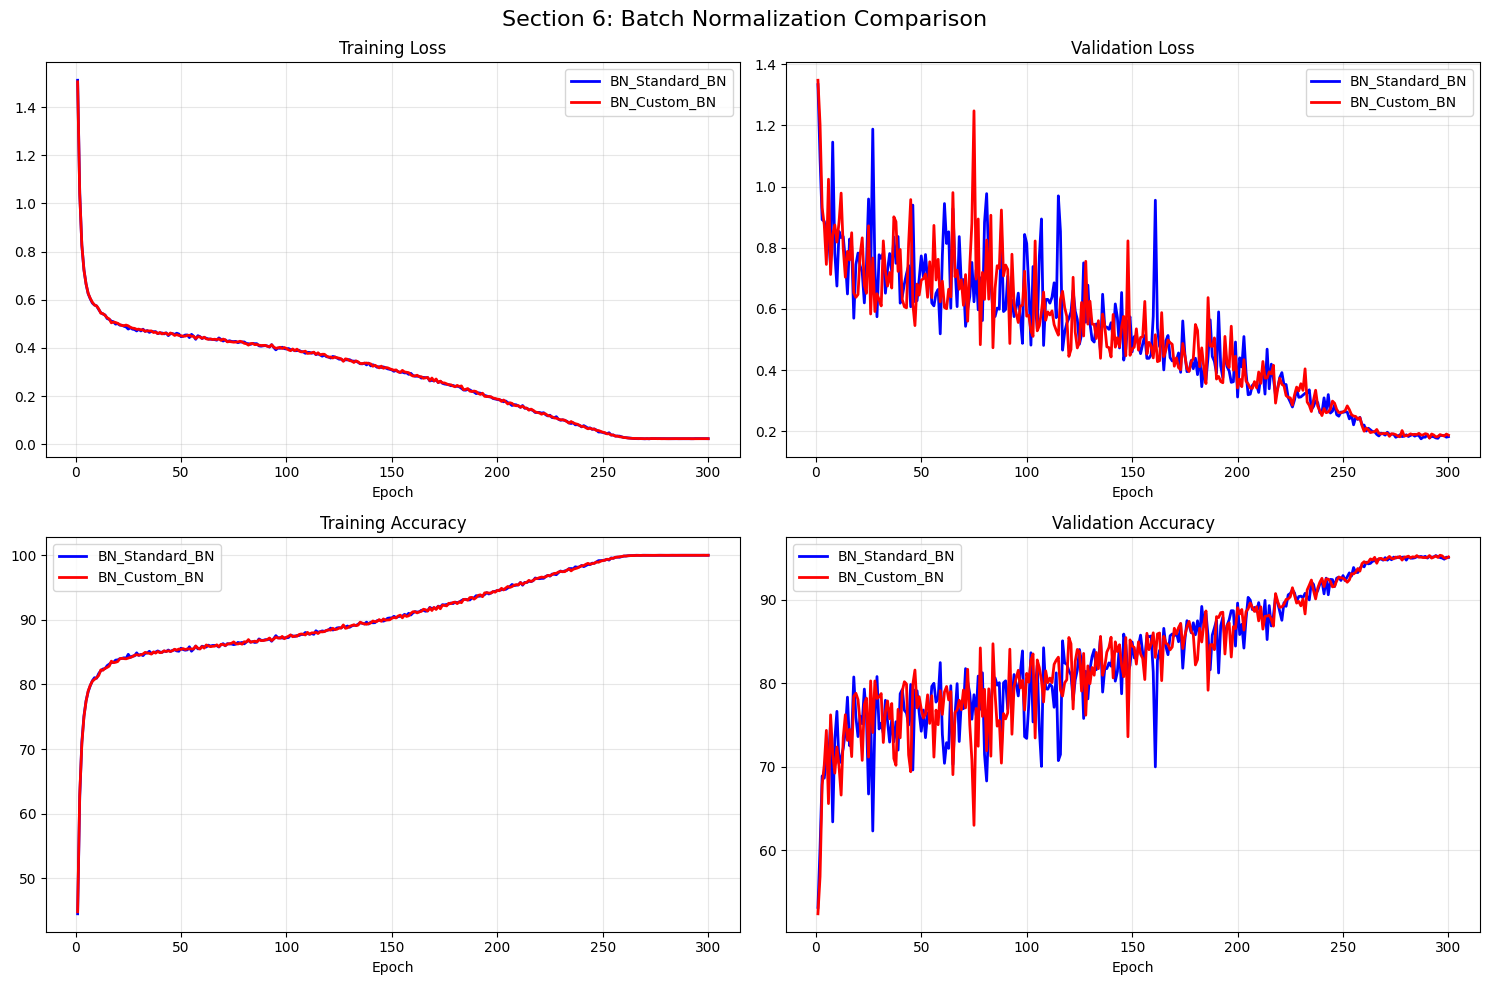


Best BatchNorm: Custom_BN

FINAL TEST EVALUATION

Best Configuration:
Learning Rate: 0.01
Scheduler: CosineAnnealing
Weight Decay: 0.01
BatchNorm: Custom_BN

Training final model for 300 epochs...


Epoch 50: LR: 0.009330, Train Loss: 0.4470, Train Acc: 85.61%, Val Loss: 0.7733, Val Acc: 74.23%


Epoch 100: LR: 0.007500, Train Loss: 0.3955, Train Acc: 87.22%, Val Loss: 0.8139, Val Acc: 73.37%


Epoch 150: LR: 0.005000, Train Loss: 0.3088, Train Acc: 90.29%, Val Loss: 0.4598, Val Acc: 84.91%


Epoch 200: LR: 0.002500, Train Loss: 0.1865, Train Acc: 94.51%, Val Loss: 0.3120, Val Acc: 89.58%


Epoch 250: LR: 0.000670, Train Loss: 0.0493, Train Acc: 99.20%, Val Loss: 0.2619, Val Acc: 92.88%


Epoch 300: LR: 0.000000, Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1824, Val Acc: 95.05%

Final Test Evaluation:


Test Loss: 0.1876, Test Accuracy: 95.04%

SUMMARY OF ALL FINAL RESULTS
LR_0.1: Train Loss: 0.4310, Train Acc: 84.95%, Val Loss: 0.5156, Val Acc: 82.10%
LR_0.01: Train Loss: 0.2552, Train Acc: 91.18%, Val Loss: 0.3950, Val Acc: 86.86%
LR_0.001: Train Loss: 0.4038, Train Acc: 85.90%, Val Loss: 0.5300, Val Acc: 81.57%
Scheduler_Constant_LR: Train Loss: 0.0022, Train Acc: 99.94%, Val Loss: 0.5089, Val Acc: 92.54%
Scheduler_CosineAnnealing: Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.4272, Val Acc: 92.93%
WD_0.0005: Train Loss: 0.0012, Train Acc: 100.00%, Val Loss: 0.2390, Val Acc: 94.15%
WD_0.01: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1824, Val Acc: 95.05%
BN_Standard_BN: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1824, Val Acc: 95.05%
BN_Custom_BN: Train Loss: 0.0232, Train Acc: 100.00%, Val Loss: 0.1872, Val Acc: 95.11%

All experiments completed successfully!


In [7]:
# ===========================
# Main experiments
# ===========================
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Section 3: Learning Rate Experiments
    print("=" * 60)
    print("SECTION 3: LEARNING RATE EXPERIMENTS")
    print("=" * 60)

    learning_rates = [0.1, 0.01, 0.001]
    lr_results = {}

    for lr in learning_rates:
        print(f"\n--- Testing Learning Rate: {lr} ---")
        set_seed(42)  # Reset seed for each experiment
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0)
        experiment_name = f'LR_{lr}'

        for epoch in range(1, 16):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, None, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)
            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        lr_results[lr] = final_result
        print(f"Final - LR {lr}: Train Loss: {final_result['train_loss']:.4f}, Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Loss: {final_result['val_loss']:.4f}, Val Acc: {final_result['val_acc']:.2f}%")

    # Plot learning rate comparison
    tracker.plot_comparison(['LR_0.1', 'LR_0.01', 'LR_0.001'],
                           "Section 3: Learning Rate Comparison",
                           save_path="lr_comparison.png")

    best_lr = max(lr_results.keys(), key=lambda x: lr_results[x]['val_acc'])
    print(f"\nBest Learning Rate: {best_lr}")


    # Section 4: Learning Rate Schedule
    print("\n" + "=" * 60)
    print("SECTION 4: LEARNING RATE SCHEDULING")
    print("=" * 60)

    # Constant LR vs Cosine Annealing
    schedulers = {
        'Constant_LR': None,
        'CosineAnnealing': optim.lr_scheduler.CosineAnnealingLR
    }

    scheduler_results = {}

    for sched_name in schedulers.keys():
        print(f"\n--- Testing Scheduler: {sched_name} ---")
        set_seed(42)
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=0)

        if sched_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
        else:
            scheduler = None

        experiment_name = f'Scheduler_{sched_name}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch}: LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        scheduler_results[sched_name] = final_result
        print(f"Final - {sched_name}: Train Loss: {final_result['train_loss']:.4f}, Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Loss: {final_result['val_loss']:.4f}, Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['Scheduler_Constant_LR', 'Scheduler_CosineAnnealing'],
                           "Section 4: Learning Rate Scheduling Comparison")

    # Section 5: Weight Decay
    print("\n" + "=" * 60)
    print("SECTION 5: WEIGHT DECAY EXPERIMENTS")
    print("=" * 60)

    weight_decays = [5e-4, 1e-2]
    wd_results = {}

    for wd in weight_decays:
        print(f"\n--- Testing Weight Decay: {wd} ---")
        set_seed(42)
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

        experiment_name = f'WD_{wd}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        wd_results[wd] = final_result
        print(f"Final - WD {wd}: Train Loss: {final_result['train_loss']:.4f}, Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Loss: {final_result['val_loss']:.4f}, Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['WD_0.0005', 'WD_0.01'],
                           "Section 5: Weight Decay Comparison")

    best_wd = max(wd_results.keys(), key=lambda x: wd_results[x]['val_acc'])
    print(f"\nBest Weight Decay: {best_wd}")

    # Section 6: Custom Batch Normalization
    print("\n" + "=" * 60)
    print("SECTION 6: CUSTOM BATCH NORMALIZATION")
    print("=" * 60)

    bn_types = [
        ('Standard_BN', False),
        ('Custom_BN', True)
    ]

    bn_results = {}

    for bn_name, use_custom in bn_types:
        print(f"\n--- Testing: {bn_name} ---")
        set_seed(42)
        net = ResNet18(use_custom_bn=use_custom).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

        experiment_name = f'BN_{bn_name}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        bn_results[bn_name] = final_result
        print(f"Final - {bn_name}: Train Loss: {final_result['train_loss']:.4f}, Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Loss: {final_result['val_loss']:.4f}, Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['BN_Standard_BN', 'BN_Custom_BN'],
                           "Section 6: Batch Normalization Comparison")

    best_bn = max(bn_results.keys(), key=lambda x: bn_results[x]['val_acc'])
    print(f"\nBest BatchNorm: {best_bn}")

    # Final Test Evaluation
    print("\n" + "=" * 60)
    print("FINAL TEST EVALUATION")
    print("=" * 60)

    print(f"\nBest Configuration:")
    print(f"Learning Rate: {best_lr}")
    print(f"Scheduler: CosineAnnealing")
    print(f"Weight Decay: {best_wd}")
    print(f"BatchNorm: {best_bn}")

    # Train final model with best configuration
    use_custom_bn = (best_bn == 'BN_Custom_BN')
    set_seed(42)
    final_net = ResNet18(use_custom_bn=use_custom_bn).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(final_net.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_wd)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

    print(f"\nTraining final model for 300 epochs...")
    best_val_acc = 0
    best_model_state = None

    for epoch in range(1, 301):
        train_loss, train_acc = train(epoch, final_net, criterion, trainloader, scheduler, optimizer)
        val_loss, val_acc = validate(epoch, final_net, criterion, valloader)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = final_net.state_dict().copy()

        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Load best model and evaluate on test set
    final_net.load_state_dict(best_model_state)

    print("\nFinal Test Evaluation:")
    test_loss, test_acc = validate(0, final_net, criterion, testloader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # Print all final results for easy copying to report
    print("\n" + "=" * 60)
    print("SUMMARY OF ALL FINAL RESULTS")
    print("=" * 60)

    experiments = [
        'LR_0.1', 'LR_0.01', 'LR_0.001',
        'Scheduler_Constant_LR', 'Scheduler_CosineAnnealing',
        'WD_0.0005', 'WD_0.01',
        'BN_Standard_BN', 'BN_Custom_BN'
    ]

    for exp_name in experiments:
        if exp_name in tracker.results:
            final = tracker.results[exp_name][-1]
            print(f"{exp_name}: Train Loss: {final['train_loss']:.4f}, Train Acc: {final['train_acc']:.2f}%, "
                  f"Val Loss: {final['val_loss']:.4f}, Val Acc: {final['val_acc']:.2f}%")

    print("\nAll experiments completed successfully!")